In [ ]:
! mkdir cuda

mkdir: cannot create directory ‘cuda’: File exists


In [ ]:
# Mount Google Drive
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! ls -la gdrive/MyDrive/Colab\ Notebooks


total 17628
-rw------- 1 root root    16693 Nov  3 22:30  Ejercicio3.ipynb
drwx------ 2 root root     4096 Nov  1 18:32  images
-rw------- 1 root root 13046008 Dec 13  2024  p4_01.ipynb
-rw------- 1 root root  1689059 Dec 13  2024 'p4_02 (1).ipynb'
-rw------- 1 root root  1250386 Dec 11  2024 'p4_02 (2).ipynb'
-rw------- 1 root root  1689043 Dec 13  2024  p4_02.ipynb
-rw------- 1 root root   283010 Nov  1 17:06  stb_image.h
-rw------- 1 root root    71221 Nov  1 17:07  stb_image_write.h


In [ ]:
!cp -r /content/gdrive/MyDrive/CAP/images/* cuda/
!ln -s /content/gdrive/MyDrive/CAP/images cuda
!cp  /content/gdrive/MyDrive/CAP/stb_image.h cuda/
!cp /content/gdrive/MyDrive/CAP/stb_image_write.h cuda

!ln -s /content/gdrive/MyDrive/CAP/stdb_image.h cuda/
!ln -s /content/gdrive/MyDrive/CAP/stdb_image_write.h cuda

!ls -la cuda/

ln: failed to create symbolic link 'cuda/images': File exists
ln: failed to create symbolic link 'cuda/stdb_image.h': File exists
ln: failed to create symbolic link 'cuda/stdb_image_write.h': File exists
total 9304
drwxr-xr-x 2 root root    4096 Nov  3 22:30 .
drwxr-xr-x 1 root root    4096 Nov  3 22:30 ..
-rw------- 1 root root  193450 Nov  3 22:36 4k_grey.jpg
-rw------- 1 root root  702701 Nov  3 22:36 4k.jpg
-rw------- 1 root root  639919 Nov  3 22:36 8k_grey.jpg
-rw------- 1 root root 5633174 Nov  3 22:36 8k.jpg
-rw------- 1 root root   63902 Nov  3 22:36 FHD_grey.jpg
-rw------- 1 root root  274739 Nov  3 22:36 FHD.jpg
-rwxr-xr-x 1 root root  160912 Nov  3 22:30 greyScaleCPU
-rw-r--r-- 1 root root    5627 Nov  3 22:30 greyScaleCPU.c
-rwxr-xr-x 1 root root 1185632 Nov  3 22:30 greyScaleGPU
-rw-r--r-- 1 root root    3538 Nov  3 22:29 greyScaleGPU.cu
-rw------- 1 root root   32845 Nov  3 22:36 HD_grey.jpg
-rw------- 1 root root  159822 Nov  3 22:36 HD.jpg
lrwxrwxrwx 1 root root      3

In [ ]:
%%writefile cuda/greyScaleGPU.cu
#include <stdio.h>
#include <stdint.h>
#include <math.h>
#include <sys/time.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"


/* Funcion de kernel*/

__global__ void greyScale(uint8_t *d_grey_image, uint8_t *d_rgb_image, int width, int height){

    int i = threadIdx.x + blockIdx.x * blockDim.x;
    int j = threadIdx.y + blockIdx.y * blockDim.y;

    if(i< width && j> height){
        int idx = (j*width + i) * 4;
        int r = d_rgb_image[idx];
        int g = d_rgb_image[idx+1];
        int b = d_rgb_image[idx+2];
        d_grey_image[j*width+i] = (uint8_t)(0.2989 * r + 0.5870 * g + 0.1140 * b);
    }

}

int main(int nargs, char **argv)
{
    int width, height, nchannels;
    struct timeval fin, ini;
    uint8_t *d_grey_image, *d_rgb_image;

    if (nargs < 2)
    {
        printf("Usage: %s <image1> [<image2> ...]\n", argv[0]);
    }
    // For each image
    // Bucle 0
    for (int file_i = 1; file_i < nargs; file_i++)
    {
        printf("[info] Processing %s\n", argv[file_i]);
        /****** Reading file ******/
        uint8_t *rgb_image = stbi_load(argv[file_i], &width, &height, &nchannels, 4);
        if (!rgb_image)
        {
            perror("Image could not be opened");
        }

        /****** Allocating memory ******/
        // - RGB2Grey
        uint8_t *grey_image = (uint8_t *)malloc(width * height);
        if (!grey_image)
        {
            perror("Could not allocate memory");
        }

        cudaMalloc((void **)&d_grey_image, width * height * sizeof(uint8_t));
        cudaMalloc((void **)&d_rgb_image, width * height * sizeof(uint8_t) * 4);
        cudaMemcpy(d_rgb_image, rgb_image, width * height * sizeof(uint8_t) * 4, cudaMemcpyHostToDevice);

        // - Filenames
        for (int i = strlen(argv[file_i]) - 1; i >= 0; i--)
        {
            if (argv[file_i][i] == '.')
            {
                argv[file_i][i] = 0;
                break;
            }
        }

        char *grey_image_filename = 0;
        asprintf(&grey_image_filename, "%s_grey.jpg", argv[file_i]);
        if (!grey_image_filename)
        {
            perror("Could not allocate memory");
            exit(-1);
        }

        /****** Computations ******/
        printf("[info] %s: width=%d, height=%d, nchannels=%d\n", argv[file_i], width, height, nchannels);

        if (nchannels != 3 && nchannels != 4)
        {
            printf("[error] Num of channels=%d not supported. Only three (RGB), four (RGBA) are supported.\n", nchannels);
            continue;
        }



        dim3 blockSize(16, 16);
        dim3 gridSize((width + blockSize.x - 1) / blockSize.x, (height + blockSize.y - 1) / blockSize.y);

        gettimeofday(&ini, NULL);
        // RGB to grey scale
        int r, g, b;
        greyScale <<<gridSize, blockSize>>> (d_grey_image, d_rgb_image, width, height);
        cudaDeviceSynchronize();
        cudaMemcpy(grey_image, d_grey_image, width * height * sizeof(uint8_t), cudaMemcpyDeviceToHost);

        gettimeofday(&fin, NULL);
        stbi_write_jpg(grey_image_filename, width, height, 1, grey_image, 10);
        free(rgb_image);

        FILE *pf = fopen("time.txt", "a");
        fprintf(pf, "%s %f\n", argv[file_i], ((fin.tv_sec * 1000000 + fin.tv_usec) - (ini.tv_sec * 1000000 + ini.tv_usec)) * 1.0 / 1000000.0);

        cudaFree(d_grey_image);
        cudaFree(d_rgb_image);
        free(grey_image_filename);
        free(grey_image);
        fclose(pf);
    }
}


In [ ]:
%%writefile cuda/greyScaleCPU.c

#include <stdio.h>
#include <stdlib.h>
#include <stdint.h>
#include <string.h>
#include <sys/time.h>
#include <immintrin.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

static inline void getRGB(uint8_t *im, int width, int height, int nchannels,
                          int x, int y, int *r, int *g, int *b) {

  unsigned char *offset = im + (x + width * y) * nchannels;
  *r = offset[0];
  *g = offset[1];
  *b = offset[2];
}

int main(int nargs, char **argv) {
  int width, height, nchannels;
  struct timeval fin, ini;

  if (nargs < 2) {
    printf("Usage: %s  [ ...]\n", argv[0]);
  }

  // For each image
  // Bucle 0
  for (int file_i = 1; file_i < nargs; file_i++) {
    printf("[info] Processing %s\n", argv[file_i]);
    /****** Reading file ******/
    uint8_t *rgb_image =
        stbi_load(argv[file_i], &width, &height, &nchannels, 4);
    if (!rgb_image) {
      perror("Image could not be opened");
    }

    /****** Allocating memory ******/
    // - RGB2Grey
    uint8_t *grey_image = malloc(width * height);
    if (!grey_image) {
      perror("Could not allocate memory");
    }

    // - Filenames
    for (int i = strlen(argv[file_i]) - 1; i >= 0; i--) {
      if (argv[file_i][i] == '.') {
        argv[file_i][i] = 0;
        break;
      }
    }

    char *grey_image_filename = 0;
    asprintf(&grey_image_filename, "%s_grey_intrin.jpg", argv[file_i]);
    if (!grey_image_filename) {
      perror("Could not allocate memory");
      exit(-1);
    }

    /****** Computations ******/
    printf("[info] %s: width=%d, height=%d, nchannels=%d\n", argv[file_i],
           width, height, nchannels);

    if (nchannels != 3 && nchannels != 4) {
      printf("[error] Num of channels=%d not supported. Only three (RGB), four "
             "(RGBA) are supported.\n",
             nchannels);
      continue;
    }

    gettimeofday(&ini, NULL);
    // RGB to grey scale

    for (int j = 0; j < height; j++) {
      for (int i = 0; i < width; i += 4) {
        __m256i orden = _mm256_setr_epi32(0, 4, 1, 5, 0, 2, 0, 1);
        __m256 coeficiente =
            _mm256_setr_ps(0.2989, 0.5870, 0.1140, 0.0, 0.2989, 0.5870, 0.1140,0.0);
        __m128i vec1 =_mm_loadl_epi64((__m128i *)(rgb_image + (i + width * j) * 4));
        __m128i vec2 =_mm_loadl_epi64((__m128i *)(rgb_image + (i + width * j) * 4 + 8));


        __m256i vec1i = _mm256_cvtepu8_epi32(vec1);
        __m256i vec2i = _mm256_cvtepu8_epi32(vec2);

        __m256 vec1f = _mm256_cvtepi32_ps(vec1i);
        __m256 vec2f = _mm256_cvtepi32_ps(vec2i);

        __m256 res1 = _mm256_mul_ps(vec1f, coeficiente);
        __m256 res2 = _mm256_mul_ps(vec2f, coeficiente);

        __m256 res = _mm256_hadd_ps(res1, res2);
        __m256 total = _mm256_hadd_ps(res, res);

        total = _mm256_permutevar8x32_ps(total, orden);
        __m128i gris = _mm_cvtps_epi32(_mm256_extractf128_ps(total, 0));


        uint32_t *ptr = (uint32_t *)&gris;

        grey_image[(j * width) + i] = ptr[0];
        grey_image[(j * width) + i + 1] = ptr[1];
        grey_image[(j * width) + i + 2] = ptr[2];
        grey_image[(j * width) + i + 3] = ptr[3];
      }
    }
    stbi_write_jpg(grey_image_filename,width,height,1, grey_image, 10);

    free(rgb_image);
    gettimeofday(&fin, NULL);
    FILE *pf = fopen("time_CPU.txt", "a");
    fprintf(pf, "%s Tiempo: %f\n", argv[file_i],
            ((fin.tv_sec * 1000000 + fin.tv_usec) -
             (ini.tv_sec * 1000000 + ini.tv_usec)) *
                1.0 / 1000000.0);
    free(grey_image_filename);
  }
}

Overwriting cuda/greyScaleCPU.c


In [33]:
!nvcc cuda/greyScaleGPU.cu -o cuda/greyScaleGPU
!gcc -O3 -march=native -fwhole-program -Wall -D_GNU_SOURCE -std=gnu99 -o cuda/greyScaleCPU cuda/greyScaleCPU.c -lm
!rm time.txt time_CPU.txt
avg = 5
for i in range(avg):
  !./cuda/greyScaleGPU cuda/images/SD.jpg cuda/images/HD.jpg cuda/images/FHD.jpg cuda/images/4k.jpg cuda/images/8k.jpg
  !./cuda/greyScaleCPU cuda/images/8k.jpg cuda/images/4k.jpg cuda/images/FHD.jpg cuda/images/HD.jpg cuda/images/SD.jpg


cuda/stb_image.h(4276): warning #550-D: variable "old_limit" was set but never used
     unsigned int cur, limit, old_limit;
                              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

cuda/stb_image.h(5185): warning #550-D: variable "idata_limit_old" was set but never used
                 stbi__uint32 idata_limit_old = idata_limit;
                              ^

cuda/stb_image.h(6972): warning #550-D: variable "out_size" was set but never used
        int out_size = 0;
            ^

cuda/stb_image.h(6973): warning #550-D: variable "delays_size" was set but never used
        int delays_size = 0;
            ^

cuda/greyScaleGPU.cu(96): warning #177-D: variable "r" was declared but never referenced
          int r, g, b;
              ^

cuda/greyScaleGPU.cu(96): warning #177-D: variable "g" was declared but never referenced
          int r, g, b;
                 ^

cuda/greyScaleGPU.cu(96): warning #177-D: variable "b" was decla

In [34]:
!cat time.txt


cuda/images/SD 0.011718
cuda/images/HD 0.000324
cuda/images/FHD 0.000636
cuda/images/4k 0.001949
cuda/images/8k 0.021889
cuda/images/SD 0.007995
cuda/images/HD 0.000324
cuda/images/FHD 0.000535
cuda/images/4k 0.001872
cuda/images/8k 0.020968
cuda/images/SD 0.007676
cuda/images/HD 0.000278
cuda/images/FHD 0.000603
cuda/images/4k 0.001911
cuda/images/8k 0.028456
cuda/images/SD 0.008058
cuda/images/HD 0.000318
cuda/images/FHD 0.000675
cuda/images/4k 0.001814
cuda/images/8k 0.021187
cuda/images/SD 0.008110
cuda/images/HD 0.000293
cuda/images/FHD 0.000620
cuda/images/4k 0.002085
cuda/images/8k 0.023276


In [35]:
!cat time_CPU.txt


cuda/images/SD Tiempo: 0.008420
cuda/images/HD Tiempo: 0.015806
cuda/images/FHD Tiempo: 0.029138
cuda/images/4k Tiempo: 0.097443
cuda/images/8k Tiempo: 0.397559
cuda/images/SD Tiempo: 0.007670
cuda/images/HD Tiempo: 0.015655
cuda/images/FHD Tiempo: 0.037320
cuda/images/4k Tiempo: 0.096823
cuda/images/8k Tiempo: 0.374476
cuda/images/SD Tiempo: 0.008660
cuda/images/HD Tiempo: 0.017854
cuda/images/FHD Tiempo: 0.031481
cuda/images/4k Tiempo: 0.116900
cuda/images/8k Tiempo: 0.634611
cuda/images/SD Tiempo: 0.012672
cuda/images/HD Tiempo: 0.022300
cuda/images/FHD Tiempo: 0.031774
cuda/images/4k Tiempo: 0.103480
cuda/images/8k Tiempo: 0.381468
cuda/images/SD Tiempo: 0.007662
cuda/images/HD Tiempo: 0.016088
cuda/images/FHD Tiempo: 0.047198
cuda/images/4k Tiempo: 0.112412
cuda/images/8k Tiempo: 0.384342


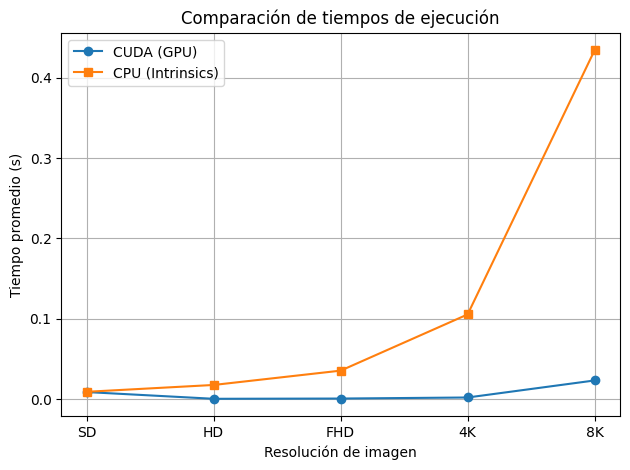

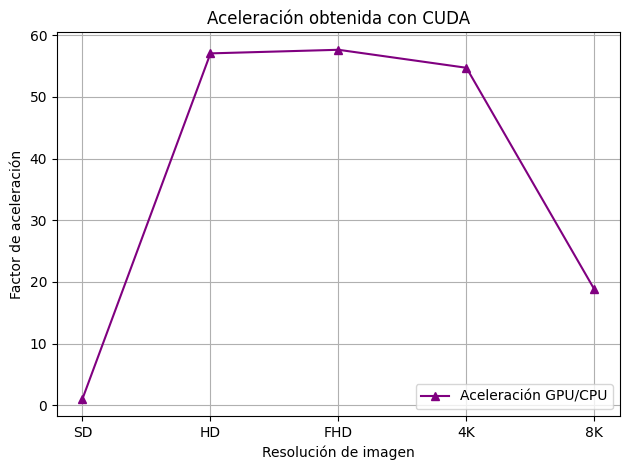

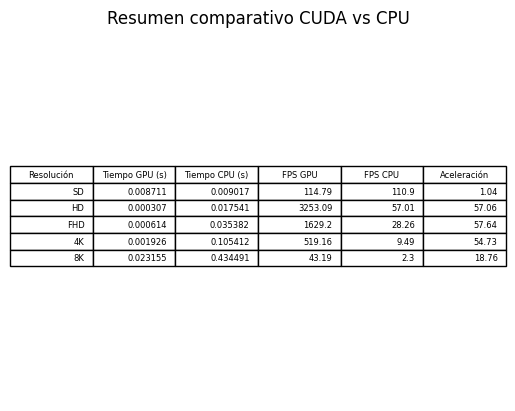

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cuda_data = pd.read_csv("time.txt", sep=' ', header=None, names=["imagen", "tiempo"])
cpu_data = pd.read_csv("time_CPU.txt", sep=' ', header=None, names=["imagen", "tiempo"])

t_cuda = cuda_data["tiempo"].values
t_cpu = cpu_data["tiempo"].values

resolutions = ["SD", "HD", "FHD", "4K", "8K"]

num_tests = avg
avg_cuda = [np.mean(t_cuda[i::num_tests]) for i in range(num_tests)]
avg_cpu = [np.mean(t_cpu[i::num_tests]) for i in range(num_tests)]

# --- Gráfic de tiempos ---
plt.figure()
plt.plot(resolutions, avg_cuda, marker='o', label="CUDA (GPU)")
plt.plot(resolutions, avg_cpu, marker='s', label="CPU (Intrinsics)")
plt.title("Comparación de tiempos de ejecución")
plt.xlabel("Resolución de imagen")
plt.ylabel("Tiempo promedio (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Cálculo de aceleración---
speedup = np.divide(avg_cpu, avg_cuda)

plt.figure()
plt.plot(resolutions, speedup, marker='^', color='purple', label="Aceleración GPU/CPU")
plt.title("Aceleración obtenida con CUDA")
plt.xlabel("Resolución de imagen")
plt.ylabel("Factor de aceleración")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Cálculo de fps---
fps_gpu = 1 / np.array(avg_cuda)
fps_cpu = 1 / np.array(avg_cpu)

tabla = pd.DataFrame({
    "Resolución": resolutions,
    "Tiempo GPU (s)": np.round(avg_cuda, 6),
    "Tiempo CPU (s)": np.round(avg_cpu, 6),
    "FPS GPU": np.round(fps_gpu, 2),
    "FPS CPU": np.round(fps_cpu, 2),
    "Aceleración": np.round(speedup, 2)
})

fig, ax = plt.subplots()
ax.axis("off")
ax.table(cellText=tabla.values, colLabels=tabla.columns, loc="center")
plt.title("Resumen comparativo CUDA vs CPU")
plt.show()
